## Topic Modeling

### Required Libraries

In [ ]:
! pip install arabic_reshaper
! pip install python-bidi
! pip install hazm
! pip install -U swifter
! pip install parsivar

In [ ]:
import pandas as pd
import hazm
import re
import codecs
import swifter
from parsivar import POSTagger

In [ ]:
! wget https://raw.githubusercontent.com/SajjadMb/Masnavi_NLP_Toolkit/main/stopwords.txt

--2022-10-16 18:47:44--  https://raw.githubusercontent.com/SajjadMb/Masnavi_NLP_Toolkit/main/stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15569 (15K) [text/plain]
Saving to: ‘stopwords.txt’

stopwords.txt       100%[===================>]  15.20K  --.-KB/s    in 0s      

2022-10-16 18:47:44 (118 MB/s) - ‘stopwords.txt’ saved [15569/15569]



In [ ]:
! gdown 1Sl_FsUCmCB_hdmT9Yzb4iUzGqEJCNrOw

Downloading...
From: https://drive.google.com/uc?id=1Sl_FsUCmCB_hdmT9Yzb4iUzGqEJCNrOw
To: /content/twitter.csv
100% 16.4M/16.4M [00:00<00:00, 38.0MB/s]


### Load Dataset

In [ ]:
twitter = pd.read_csv("twitter.csv", index_col=0)

In [ ]:
twitter.head()

,tweet,hashtags
0,هرکس که رفته کربلا از این حرم رفتبا نام مشهد ک...,[]
1,سروده زیبا از پروین اعتصامیزن در ایران پیش از ...,[]
2,مگه هنوز احمقی هست که خودش رو اصلاح طلب بدونه ...,[]
3,کلیپ آرشیو نرگس محمدی از شکنجه میگوید چهل سال ...,['#چهل_سال_شکنجه#40YearsOfTorture✊✊✊']
4,همونجا آب جوشی چای چیزی میگرفتی میریختی روش از...,[]


In [ ]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tweet     100000 non-null  object
 1   hashtags  100000 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


### Clean Dataset

In [ ]:
import re

wierdPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)

def clean_wierd_patterns(text):
    return wierdPatterns.sub(r'', text)

In [ ]:
def remove_url(text):
    text = ' '.join(x for x in text.split() if x.startswith('http') == False and x.startswith('www') == False)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^www?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # extra step to make sure html tags are completely removed
    clean = re.compile('<.*>|<.*\"')
    result = re.sub(clean, '', text)
    return result

In [ ]:
def remove_mentions(text):
    tweet = []
    for token in text.split():
        if not token.startswith("@") and not token.startswith("&amp"):
            tweet.append(token.strip())
    return " ".join(tweet)

In [ ]:
def clean_tweet(tweet):
    tweet = tweet.replace("#", "").replace("_", " ")
    tweet = remove_mentions(tweet)
    tweet = remove_url(tweet)
    tweet = clean_wierd_patterns(tweet)
    return tweet

In [ ]:
twitter['tweet'] = twitter['tweet'].swifter.apply(clean_tweet)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
def remove_spaces_reg():
    # return space patterns
    space_pattern = r"[\xad\ufeff\u200e\u200d\u200b\x7f\u202a\u2003\xa0\u206e\u200c\x9d]"
    return re.compile(space_pattern)

In [ ]:
def remove_symbols_reg():
    # return symbol patterns
    symbol_patterns = r"(\d|\"|'ٍ|¬|[؛“،,”‘۔’’‘–]|[|\.÷+\:\-\؟?»\=\{}\*«»_…\؟!/ـ]|[۰'ٓ۫'ٔ]|[ٓٔ]|[ًٌٍْﹼ،َُِّ«ٰ»ٖء]|[\(\)])"
    return re.compile(symbol_patterns)

In [ ]:
def remeove_arabic(text):
    # remove arabic alphabet
    mapping = {
        u"ۀ" : u"ه",
        u"ة" : u"ت",
        u"ي" : u"ی",
        u"ؤ" : u"و",
        u"إ" : u"ا",
        u"ٹ" : u"ت",
        u"ڈ" : u"د",
        u"ئ" : u"ی",
        u"ﻨ" : u"ن",
        u"ﺠ" : u"ج",
        u"ﻣ" : u"م",
        u"ﷲ" : u"",
        u"ﻳ" : u"ی",
        u"ٻ" : u"ب",
        u"ٱ" : u"ا",
        u"ڵ" : u"ل",
        u"ﭘ" : u"پ",
        u"ﻪ" : u"ه",
        u"ﻳ" : u"ی",
        u"ٻ" : u"ب",
        u"ں" : u"ن",
        u"ٶ" : u"و",
        u"ٲ" : u"ا",
        u"ہ" : u"ه",
        u"ﻩ" : u"ه",
        u"ﻩ" : u"ه",
        u"ك" : u"ک",
        u"ﺆ" : u"و",
        u"أ" : u"ا",
        u"ﺪ" : u"د"
    }

    arabic_keys =  re.compile(r"(" + "|".join(mapping.keys()) + r")")
    return arabic_keys.sub(lambda x: mapping[x.group()], text)

In [ ]:
spaces_reg = remove_spaces_reg() 
symbols_reg = remove_symbols_reg()

In [ ]:
stopwords = [x.strip() for x in codecs.open('stopwords.txt','r','utf-8').readlines()]

In [ ]:
normalizer = hazm.Normalizer()

In [ ]:
def clean_text(text):
    text = re.sub(symbols_reg, "", text)
    text = remeove_arabic(text)
    text = normalizer.normalize(text)
    regex = r"\b(?:" + "|".join(map(re.escape, stopwords)) + r")\b"
    text = re.sub(regex, " ", text)
    text = re.sub(spaces_reg, " ", text)
    text = re.sub("(\s)+", " ", text)
    text = text.strip()
    return text

In [ ]:
stemmer = hazm.Stemmer()
tagger = POSTagger(tagging_model="wapiti")

In [ ]:
twitter["tokens"] = twitter["tweet"].swifter.apply(
    lambda x: [word for word, pos in tagger.parse(hazm.word_tokenize(clean_text(x))) if not pos.startswith("V_")]
    )

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
twitter.head()

,tweet,hashtags,tokens
0,هرکس که رفته کربلا از این حرم رفتبا نام مشهد ک...,[],"[کربلا, حرم, رفتبا, مشهد, کربلا]"
1,سروده زیبا از پروین اعتصامیزن در ایران پیش از ...,[],"[سروده, زیبا, پروین, اعتصامیزن, ایران, ایرانی,..."
2,مگه هنوز احمقی هست که خودش رو اصلاح طلب بدونه ...,[],"[مگه, احمقی, اصلاح, طلب, بدونه, اصلاحات, امید,..."
3,کلیپ آرشیو نرگس محمدی از شکنجه میگوید چهل سال ...,['#چهل_سال_شکنجه#40YearsOfTorture✊✊✊'],"[کلیپ, آرشیو, نرگس, محمدی, شکنجه, چهل, شکنجهYe..."
4,همونجا آب جوشی چای چیزی میگرفتی میریختی روش از...,[],"[همونجا, آب, جوشی, چای, میریختی, عمق, فاجعه, ن..."


In [ ]:
from itertools import chain

all_words = list(chain.from_iterable(twitter.tokens))

In [ ]:
import nltk

words_frequencies = nltk.FreqDist(all_words).most_common(100)

In [ ]:
words_frequencies[:10]

[('ایران', 7366),
 ('داره', 2607),
 ('انقلاب', 2451),
 ('آمریکا', 2387),
 ('اسلامی', 2043),
 ('دست', 1978),
 ('کار', 1912),
 ('باشه', 1753),
 ('دوست', 1702),
 ('میشه', 1589)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [ ]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [ ]:
tf = tf_vectorizer.fit_transform(all_words)

In [ ]:
lda = LatentDirichletAllocation(
    n_components=4,
    max_iter=5,
    learning_method="batch",
    learning_offset=50.0,
    random_state=0
)

In [ ]:
lda.fit(tf)

LatentDirichletAllocation(learning_offset=50.0, max_iter=5, n_components=4,
                          random_state=0)

In [ ]:
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import seaborn as sns

def make_farsi_text(x):
    if x == 'الله':
        return 'هللا'
    reshaped_text = reshape(x)
    farsi_text = get_display(reshaped_text)
    return farsi_text

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 1, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [ ]:
tf_feature_names = [make_farsi_text(t) for t in tf_feature_names]

In [ ]:
top_words = 10

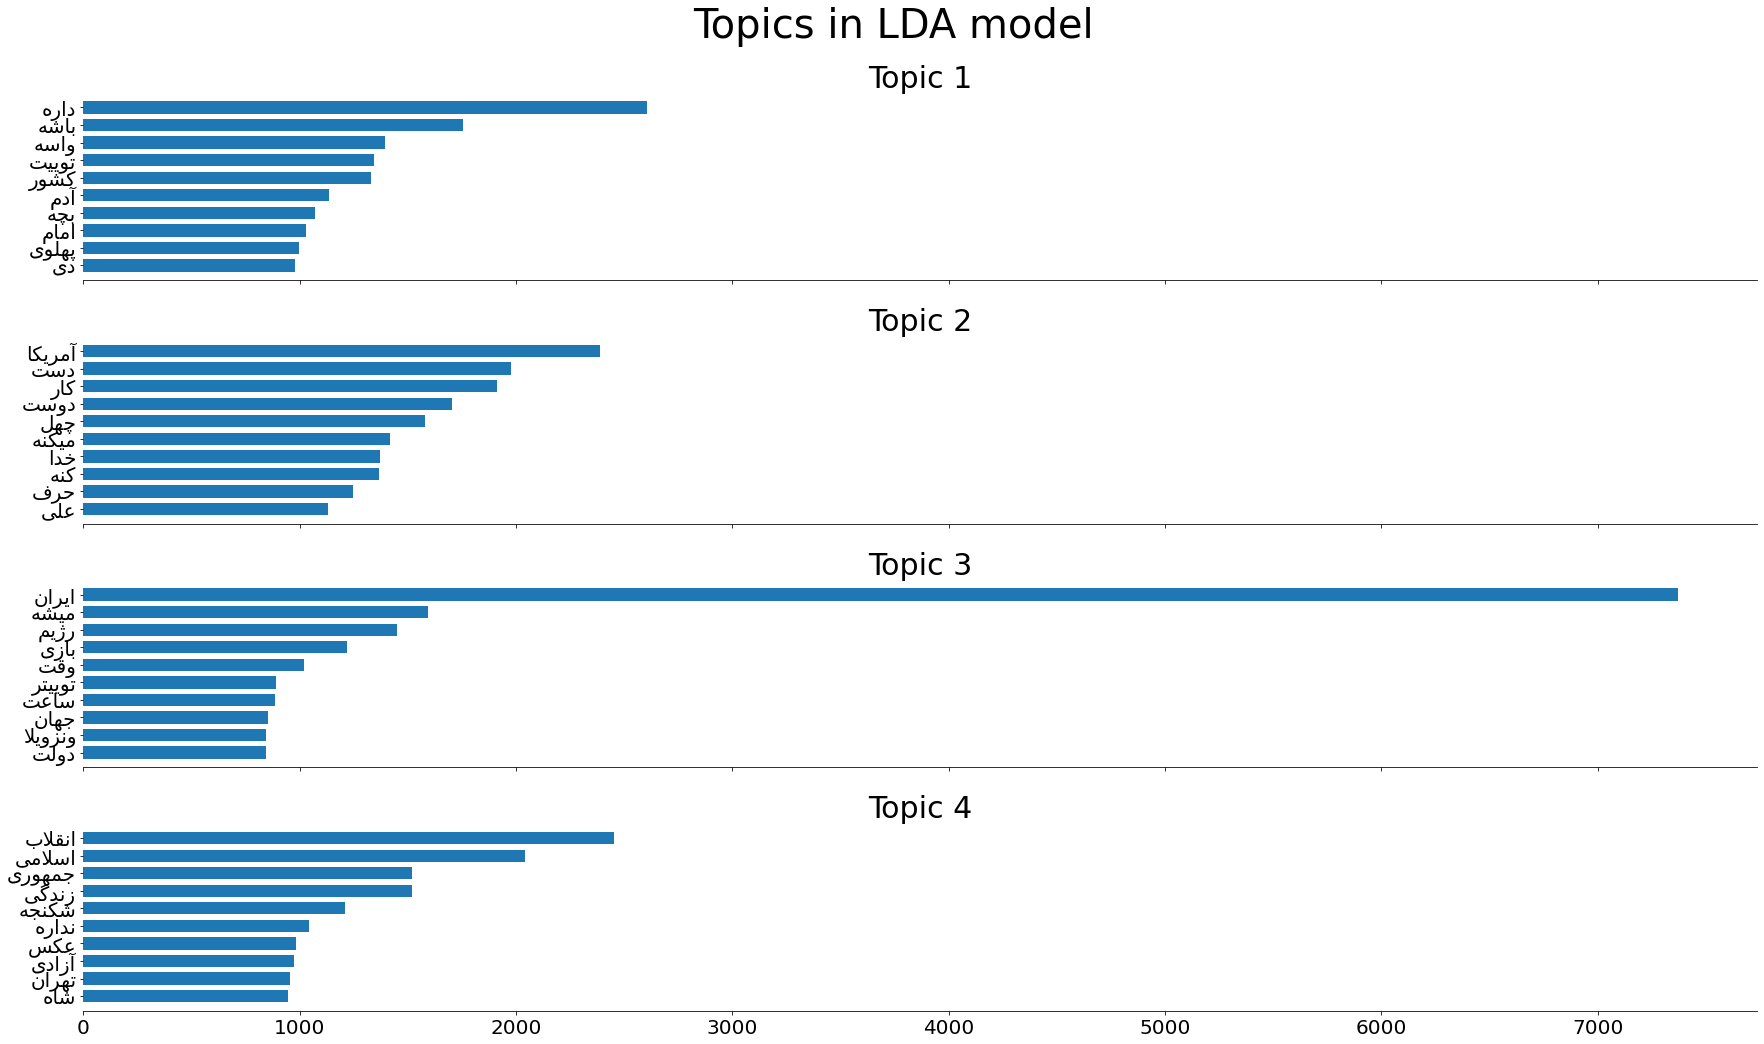

In [ ]:
plot_top_words(lda, tf_feature_names, top_words, "Topics in LDA model")

In [ ]:
twitter.head(500)